# Forecasting Order Amount of Olist Store

In [ ]:
# Import libraries
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# basic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

#prophet
from fbprophet import Prophet
from fbprophet.plot import plot_plotly

#statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#evaluation
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error,mean_squared_error, mean_absolute_percentage_error
import math

#warnings
import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)

## Data Preparation

In [ ]:
# load dataset
data = pd.read_csv("/content/drive/MyDrive/forecast_olist/data_analysis_1.csv")
data

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,product_category_name,payment_value
0,12950f3d9bc12065fc5da141faab5780,5e6916fe2fcc2d982cc64eb97f593b92,delivered,2018-06-29 22:06:25,2018-07-02 09:30:32,papelaria,103.82
1,1594012ccc1b0770373ce691d697e5ae,e957d597f76d275f40a848397fb6c7c3,delivered,2018-04-23 19:05:57,2018-04-24 19:17:00,cama_mesa_banho,362.17
2,257699bfe87de4eac234324e88db828a,047c4f9e8ca120c41c8d4a61df722ea2,delivered,2018-05-15 14:16:57,2018-05-15 14:35:47,brinquedos,102.26
3,230429e6f253f9cd6561aad72ce7ee2f,a7924be36d69088596f4ceb0178adf28,delivered,2018-07-18 13:30:45,2018-07-19 15:30:27,casa_construcao,131.71
4,09249f4625a56408772a45322aadd544,9d4454db8535593c2a2f165869f30bc5,delivered,2018-08-07 10:19:43,2018-08-07 10:35:16,beleza_saude,138.84
...,...,...,...,...,...,...,...
103311,a7dfcc78536e420e85e510d7bb161cb4,9d07ed48127e776f64b02de9aa00c136,delivered,2017-12-22 01:09:21,2017-12-22 01:18:31,automotivo,39.00
103312,79d7ad461229b660db59a892f1fa8e1b,9652611b6a6c44d8631be8f89e656867,delivered,2017-09-07 01:26:35,2017-09-09 05:04:00,ferramentas_jardim,77.57
103313,9a5ea74a2fd85889e60e9bdb186cd1f0,c9722642f74a37fb4d28e4d5d65c20aa,delivered,2017-11-30 13:33:13,2017-11-30 13:58:33,pet_shop,155.23
103314,1091b52a01d06a2bf1e97ca70cb2d75a,a2ccdcdf92fa5b6f0cf2a320924ba362,delivered,2018-04-10 00:19:43,2018-04-10 00:35:28,consoles_games,33.56


### Data Check

In [ ]:
# check columns
data.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'product_category_name', 'payment_value'],
      dtype='object')

Since in our dataset is result of many merge of columns, so we have to check is the order_id unique? or not. Order_id have to be unique because it means id that generated when customer wants to order product from Olist Store.

In [ ]:
# make sure that order_id is unique
data['order_id'].value_counts()>1

fa65dad1b0e818e3ccc5cb0e39231352     True
ccf804e764ed5650cd8759557269dc13     True
68986e4324f6a21481df4e6e89abcf01     True
285c2e15bebd4ac83635ccc563dc71f4     True
ee9ca989fc93ba09a6eddc250ce01742     True
                                    ...  
5fbe2b81bb0cd59643b435d2ffcad024    False
a916ef54d66196808d8852471ef39edf    False
311f11836437bf8950d50701fb64fcbf    False
a139630cbe2c9106179e382ba9e9d517    False
5bd233924f0b9c52492bd5a92e5ab2d3    False
Name: order_id, Length: 98665, dtype: bool

In [ ]:
# see duplicated data
data.duplicated().sum()

0

As we can see above, **there're some order_id more than 1**. But when we check **duplicated data is null**. Let's see what happened in our order_id.

In [ ]:
## get our sample of duplicted order_id

data[data['order_id']=="ccf804e764ed5650cd8759557269dc13"]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,product_category_name,payment_value
69472,ccf804e764ed5650cd8759557269dc13,92cd3ec6e2d643d4ebd0e3d6238f69e2,delivered,2017-06-07 12:05:10,2017-06-09 16:15:08,cama_mesa_banho,1.11
69473,ccf804e764ed5650cd8759557269dc13,92cd3ec6e2d643d4ebd0e3d6238f69e2,delivered,2017-06-07 12:05:10,2017-06-09 16:15:08,cama_mesa_banho,0.99
69474,ccf804e764ed5650cd8759557269dc13,92cd3ec6e2d643d4ebd0e3d6238f69e2,delivered,2017-06-07 12:05:10,2017-06-09 16:15:08,cama_mesa_banho,1.07
69475,ccf804e764ed5650cd8759557269dc13,92cd3ec6e2d643d4ebd0e3d6238f69e2,delivered,2017-06-07 12:05:10,2017-06-09 16:15:08,cama_mesa_banho,1.45
69476,ccf804e764ed5650cd8759557269dc13,92cd3ec6e2d643d4ebd0e3d6238f69e2,delivered,2017-06-07 12:05:10,2017-06-09 16:15:08,cama_mesa_banho,2.45
69477,ccf804e764ed5650cd8759557269dc13,92cd3ec6e2d643d4ebd0e3d6238f69e2,delivered,2017-06-07 12:05:10,2017-06-09 16:15:08,cama_mesa_banho,1.40
69478,ccf804e764ed5650cd8759557269dc13,92cd3ec6e2d643d4ebd0e3d6238f69e2,delivered,2017-06-07 12:05:10,2017-06-09 16:15:08,cama_mesa_banho,0.97
69479,ccf804e764ed5650cd8759557269dc13,92cd3ec6e2d643d4ebd0e3d6238f69e2,delivered,2017-06-07 12:05:10,2017-06-09 16:15:08,cama_mesa_banho,2.42
69480,ccf804e764ed5650cd8759557269dc13,92cd3ec6e2d643d4ebd0e3d6238f69e2,delivered,2017-06-07 12:05:10,2017-06-09 16:15:08,cama_mesa_banho,1.20
69481,ccf804e764ed5650cd8759557269dc13,92cd3ec6e2d643d4ebd0e3d6238f69e2,delivered,2017-06-07 12:05:10,2017-06-09 16:15:08,cama_mesa_banho,1.03


In [ ]:
## check in 1 product category name have more than 1 order_id
data[data['product_category_name']=="cama_mesa_banho"]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,product_category_name,payment_value
1,1594012ccc1b0770373ce691d697e5ae,e957d597f76d275f40a848397fb6c7c3,delivered,2018-04-23 19:05:57,2018-04-24 19:17:00,cama_mesa_banho,362.17
19,0a62a2ee479a419db8aebf78129b2f5e,253c9223dfa3bf75327514da2145fe9d,delivered,2017-10-01 21:45:41,2017-10-01 22:04:56,cama_mesa_banho,131.61
20,103407760762721e1dbb7247b5f7c331,6ead49cdaaf1f5b7c003a60d336fce13,delivered,2018-08-08 14:22:09,2018-08-08 14:35:17,cama_mesa_banho,48.30
57,0efd6177ac7aab7f85f78796d324b321,f37b7cd28154c2c80457b37f12e06247,delivered,2017-06-15 18:43:48,2017-06-15 18:55:12,cama_mesa_banho,73.43
117,8e69cb6bacc0ad1b8f16f6990e9375ac,3d0b25a53e5aa536ae355886c606ed5e,delivered,2018-03-24 09:37:26,2018-03-24 11:41:17,cama_mesa_banho,88.90
...,...,...,...,...,...,...,...
103271,a0190a8aa681fe129b9a9ae80dfd9266,79e2f6247cc5228c7deee6c5f8987669,delivered,2018-07-01 12:01:07,2018-07-01 12:10:14,cama_mesa_banho,59.82
103290,dbd1cbc05d31e4c71790b63eb1fc870f,56db29d910656521640dd459604f55eb,delivered,2017-08-15 16:13:41,2017-08-15 17:25:48,cama_mesa_banho,226.24
103295,a72fc5669df669ab2c501cd323698fac,05ad4097a892d5d8163107dd0bc3ca2d,delivered,2018-02-27 21:15:55,2018-02-28 12:50:25,cama_mesa_banho,116.92
103301,da17a7a38c09dce18dcf5af9fdb27e49,ec2ba159df14ccd6ba99107d18c1681b,delivered,2018-05-08 17:46:50,2018-05-10 03:09:50,cama_mesa_banho,95.36


In [ ]:
data['customer_id'].value_counts()

9af2372a1e49340278e7c1ef8d749f34    25
92cd3ec6e2d643d4ebd0e3d6238f69e2    22
86cc80fef09f7f39df4b0dbce48e81cb    20
b246eeed30b362c09d867b9e598bee51    19
eed931d3a5222a9a511d18be7fd2a5ba    17
                                    ..
a19fe9f70875f312739724f0ac17fe63     1
c3e03d1569832dcb3cdfa2ea53369220     1
cd600417f3ba94952c8c4114a4f91264     1
beb9271894cf44c6d9997233fdcc9603     1
d7475a536385854da614094f0bf12275     1
Name: customer_id, Length: 98665, dtype: int64

In [ ]:
## check in 1 customer_id have the same order_id even in different times
data[data['customer_id']=="eed931d3a5222a9a511d18be7fd2a5ba"]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,product_category_name,payment_value
3304,ee9ca989fc93ba09a6eddc250ce01742,eed931d3a5222a9a511d18be7fd2a5ba,delivered,2017-05-12 16:24:51,2017-05-12 16:35:21,cama_mesa_banho,5.31
65547,ee9ca989fc93ba09a6eddc250ce01742,eed931d3a5222a9a511d18be7fd2a5ba,delivered,2017-05-12 16:24:51,2017-05-12 16:35:21,cama_mesa_banho,1.92
65548,ee9ca989fc93ba09a6eddc250ce01742,eed931d3a5222a9a511d18be7fd2a5ba,delivered,2017-05-12 16:24:51,2017-05-12 16:35:21,cama_mesa_banho,3.90
65549,ee9ca989fc93ba09a6eddc250ce01742,eed931d3a5222a9a511d18be7fd2a5ba,delivered,2017-05-12 16:24:51,2017-05-12 16:35:21,cama_mesa_banho,2.45
65550,ee9ca989fc93ba09a6eddc250ce01742,eed931d3a5222a9a511d18be7fd2a5ba,delivered,2017-05-12 16:24:51,2017-05-12 16:35:21,cama_mesa_banho,3.75
65551,ee9ca989fc93ba09a6eddc250ce01742,eed931d3a5222a9a511d18be7fd2a5ba,delivered,2017-05-12 16:24:51,2017-05-12 16:35:21,cama_mesa_banho,4.56
65552,ee9ca989fc93ba09a6eddc250ce01742,eed931d3a5222a9a511d18be7fd2a5ba,delivered,2017-05-12 16:24:51,2017-05-12 16:35:21,cama_mesa_banho,2.33
65553,ee9ca989fc93ba09a6eddc250ce01742,eed931d3a5222a9a511d18be7fd2a5ba,delivered,2017-05-12 16:24:51,2017-05-12 16:35:21,cama_mesa_banho,3.58
65554,ee9ca989fc93ba09a6eddc250ce01742,eed931d3a5222a9a511d18be7fd2a5ba,delivered,2017-05-12 16:24:51,2017-05-12 16:35:21,cama_mesa_banho,3.49
65555,ee9ca989fc93ba09a6eddc250ce01742,eed931d3a5222a9a511d18be7fd2a5ba,delivered,2017-05-12 16:24:51,2017-05-12 16:35:21,cama_mesa_banho,2.80


Supposedly customer_id is an identifier, and logically each customer can make purchase orders at different times, as well as different items when viewed from the payment_value made.

But here we find data for one customer_id, they have the same order_id and the same order_approved_at. The only difference is the payment_value. So it is possible for a customer to place an order once but at the same time in large quantities and also with different items. So one time payment is called one time order, and this makes sense. So we can move on to the next process.

In [ ]:
# check is there order_approved_at that earlier than order_purchase
data[data['order_purchase_timestamp'] > data['order_approved_at']]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,product_category_name,payment_value


our data is proper because there is no any approved order that earlier than puchase date, puchase must be earlier since after that the application approve it.

In [ ]:
# check count of each order status
data['order_status'].value_counts()

delivered      101024
shipped          1162
canceled          485
invoiced          323
processing        314
unavailable         6
approved            2
Name: order_status, dtype: int64

In [ ]:
# check how the condition of canceled order
data[data['order_status']=="canceled"]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,product_category_name,payment_value
360,d01c5b46e00bd214519fe9f64bbb2649,c14683c13fb7e9f39e4228f207eb05a8,canceled,2017-03-13 20:30:13,2017-03-13 20:30:13,NaN,93.72
404,61792c6272346d7f4b7c5b1747df7b1a,6d6221343635319264386c8f977b01de,canceled,2017-03-08 11:51:41,2017-03-08 12:33:15,telefonia,49.34
439,5627a31940ca40213ead4a6a71e7b386,48d301b5b8df06178be995e0ae887bbe,canceled,2018-05-21 12:22:10,2018-05-21 15:34:08,beleza_saude,69.14
467,4a63bdb264d95eae86109b24b4880aee,e3ecae2c1c7408b84d64573d0f264d78,canceled,2018-03-26 11:59:06,2018-03-26 19:50:10,bebes,61.29
674,5d9c5817e278892b7498d90bfa28ade8,b583a7efe4522c8ce8942bd47f33d487,canceled,2018-04-26 08:13:54,2018-04-26 08:32:52,pet_shop,290.16
...,...,...,...,...,...,...,...
102251,7fa41d59cc693e0ed84f2668b7ebe4d7,7cdd54eb1841f58ded0defbadb8820f6,canceled,2017-07-13 18:10:28,2017-07-13 18:25:09,informatica_acessorios,84.02
102274,da7af77d5f98212a8c1ad0b1c552f102,24cf7b32fc941c030828ad85d84769f7,canceled,2017-07-16 10:46:54,2017-07-16 11:02:54,esporte_lazer,464.34
102434,7d92b1e737c6ee25a66b4bddf1f8be8d,b52dc9b0b38a7c414ffb6da8aec8d27d,canceled,2017-09-01 22:43:44,2017-09-01 22:55:23,esporte_lazer,63.33
102614,374bd3371c572eff1218edb0eb68cb96,17df09c17e859d9c328292bf6444ba9c,canceled,2018-02-14 03:35:04,2018-02-14 03:50:30,brinquedos,83.90


As we know the counts of each order status, so we know to the sum of that is the same with total order that we have. It means there is no data that have double order status in the same order_id and customer_id.

Order status with **canceled** means the order canceled, so we don't need this data since we want to know how the much count of order overtime.
The same treatment for **unavailable** status.

In [ ]:
## recreate dataset

data_check = data[data['order_status']!='canceled']
data_check = data[data['order_status']!='unavailable']
data_check

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,product_category_name,payment_value
0,12950f3d9bc12065fc5da141faab5780,5e6916fe2fcc2d982cc64eb97f593b92,delivered,2018-06-29 22:06:25,2018-07-02 09:30:32,papelaria,103.82
1,1594012ccc1b0770373ce691d697e5ae,e957d597f76d275f40a848397fb6c7c3,delivered,2018-04-23 19:05:57,2018-04-24 19:17:00,cama_mesa_banho,362.17
2,257699bfe87de4eac234324e88db828a,047c4f9e8ca120c41c8d4a61df722ea2,delivered,2018-05-15 14:16:57,2018-05-15 14:35:47,brinquedos,102.26
3,230429e6f253f9cd6561aad72ce7ee2f,a7924be36d69088596f4ceb0178adf28,delivered,2018-07-18 13:30:45,2018-07-19 15:30:27,casa_construcao,131.71
4,09249f4625a56408772a45322aadd544,9d4454db8535593c2a2f165869f30bc5,delivered,2018-08-07 10:19:43,2018-08-07 10:35:16,beleza_saude,138.84
...,...,...,...,...,...,...,...
103311,a7dfcc78536e420e85e510d7bb161cb4,9d07ed48127e776f64b02de9aa00c136,delivered,2017-12-22 01:09:21,2017-12-22 01:18:31,automotivo,39.00
103312,79d7ad461229b660db59a892f1fa8e1b,9652611b6a6c44d8631be8f89e656867,delivered,2017-09-07 01:26:35,2017-09-09 05:04:00,ferramentas_jardim,77.57
103313,9a5ea74a2fd85889e60e9bdb186cd1f0,c9722642f74a37fb4d28e4d5d65c20aa,delivered,2017-11-30 13:33:13,2017-11-30 13:58:33,pet_shop,155.23
103314,1091b52a01d06a2bf1e97ca70cb2d75a,a2ccdcdf92fa5b6f0cf2a320924ba362,delivered,2018-04-10 00:19:43,2018-04-10 00:35:28,consoles_games,33.56


## Exploratory Data Analysis

First, we want to know when the largest orders is happened? It's helpful for know the term of customer consumption.

In [ ]:
# recreate date time for order_approved_at
data_check['order_approved_at'] = data['order_approved_at'].astype("datetime64[ns]")
data_check['order_app_date'] = data['order_approved_at'].dt.strftime("%Y-%m-%d").astype('datetime64[ns]')

In [ ]:
data_check.groupby(['order_app_date'])[['order_id']].count().sort_values(by='order_id',ascending=False)

,order_id
order_app_date,
2018-04-24,1038
2017-11-24,827
2017-11-25,785
2018-07-05,717
2017-11-28,517
...,...
2017-01-09,4
2016-10-13,3
2017-01-05,3


penjualan terbanyak ada di tanggal 24 bulan april 2018.

Then why on that day there were so many purchases? what happened? from whose customer?

In [ ]:
# create dataset special on april 24, 2018
april_2418 = data_check[data_check['order_app_date']=="2018-04-24"]

In [ ]:
april_2418['customer_id'].value_counts()

caed95700dcb091eeaac59a97fe0cb17    4
1ee3f2411ad5097d580f5d8bbf3cd63f    3
e1e157f3dbfc5df809751ed8f7fbfd5a    3
21de634855f444443723e6c8b224ae69    3
e14b08a5e109d77846ce7d4cb8b12d6c    2
                                   ..
23706c2bdb0f3c73d411a126e1cb9a7a    1
46777be868cf25df4587888868aaba43    1
5980c373bec269238b18136eb1675900    1
7c9c1015111c84b3feff7011e229470d    1
42fc8a799c40493b77e9bf7edbcdc286    1
Name: customer_id, Length: 990, dtype: int64

From the table above, we can see that the highest number of orders was 3, so it can be said that the purchase was evenly distributed per each customer on April 24 2018, so the high number of orders on that day was purely due to many new customers buying goods at olist shop, not an old customer, this could be due to a sale that might be promoted on that day so that sales soared and the most purchased items were in the beleza_saude or beauty category.

In [ ]:
# check the most purchased product category on 24042018
april_2418['product_category_name'].value_counts()

beleza_saude                                      106
cama_mesa_banho                                    88
relogios_presentes                                 83
moveis_decoracao                                   75
esporte_lazer                                      64
utilidades_domesticas                              62
informatica_acessorios                             48
telefonia                                          46
automotivo                                         42
ferramentas_jardim                                 39
brinquedos                                         37
cool_stuff                                         33
bebes                                              31
perfumaria                                         29
eletronicos                                        23
pet_shop                                           22
papelaria                                          22
fashion_bolsas_e_acessorios                        16
eletrodomesticos            

And yes, the best-selling products that can be included as outliers are product categories 59 and 60. Maybe because that day there was a sale on these products. And it could be that the beauty product category is the item that is most in demand or needed by customers, so we also need to find out about which products are selling well overall.

In [ ]:
# check the best selling product overall
data_check['product_category_name'].value_counts()

cama_mesa_banho                                  9944
beleza_saude                                     9062
esporte_lazer                                    7954
informatica_acessorios                           6906
moveis_decoracao                                 6750
                                                 ... 
portateis_cozinha_e_preparadores_de_alimentos      14
cds_dvds_musicais                                  12
pc_gamer                                            9
fashion_roupa_infanto_juvenil                       8
seguros_e_servicos                                  2
Name: product_category_name, Length: 73, dtype: int64

And yes, it turns out that the beleza_saude (beauty) and cama_mesa_banho (home furnishings) categories are the best-selling category products overall.

In [ ]:
## recreate date for monthly

data_check['date_monthly'] = data_check['order_app_date'].dt.strftime("%Y-%m")
data_check['date_monthly']

0         2018-07
1         2018-04
2         2018-05
3         2018-07
4         2018-08
           ...   
103311    2017-12
103312    2017-09
103313    2017-11
103314    2018-04
103315    2018-05
Name: date_monthly, Length: 103310, dtype: object

In [ ]:
# check revenue overtime from total payment value monthly

rev_overtime = data_check.groupby(['date_monthly'])[['payment_value']].sum().sort_values(by='date_monthly').drop(index=['2016-10', '2016-12', '2018-09'])

In [ ]:
# check count of order overtime from total order monthly

order_overtime = data_check.groupby(['date_monthly'])[['order_id']].count().sort_values(by='date_monthly').drop(index=['2016-10', '2016-12', '2018-09'])

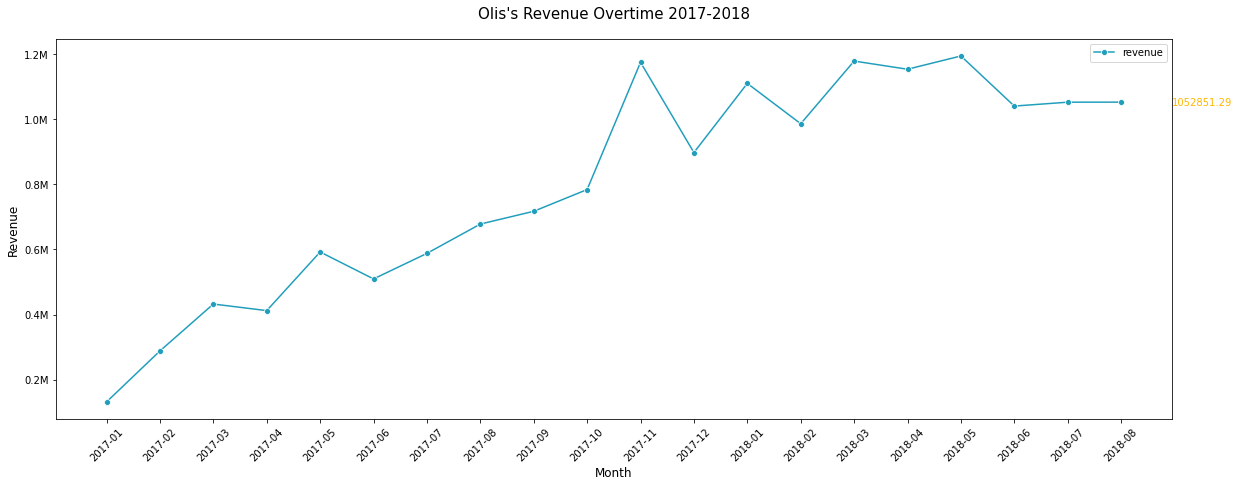

In [ ]:
#visualize 
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
def millions(x, pos):
    return '%1.1fM' % (x * 1e-6)


formatter = FuncFormatter(millions)
plt.figure(figsize=(20,7))
ax1 = sns.lineplot(x=rev_overtime.index, y="payment_value", data=rev_overtime, ci=None, marker='o', color='#219ebc',label='revenue')
plt.title("Olis's Revenue Overtime 2017-2018", fontsize=15, pad=20)
for l in ax1.lines:
    y = l.get_ydata()
    if len(y)>0:
        ax1.annotate(f'{y[-1]:.2f}', xy=(1,y[-1]), xycoords=('axes fraction', 'data'), 
                     ha='left', va='center', color="#ffb703")
plt.xticks(rotation=45)
ax1.yaxis.set_major_formatter(formatter)
plt.ylabel("Revenue", fontsize=12)
plt.xlabel("Month", fontsize=12)
plt.grid(False)
plt.legend()
plt.show()

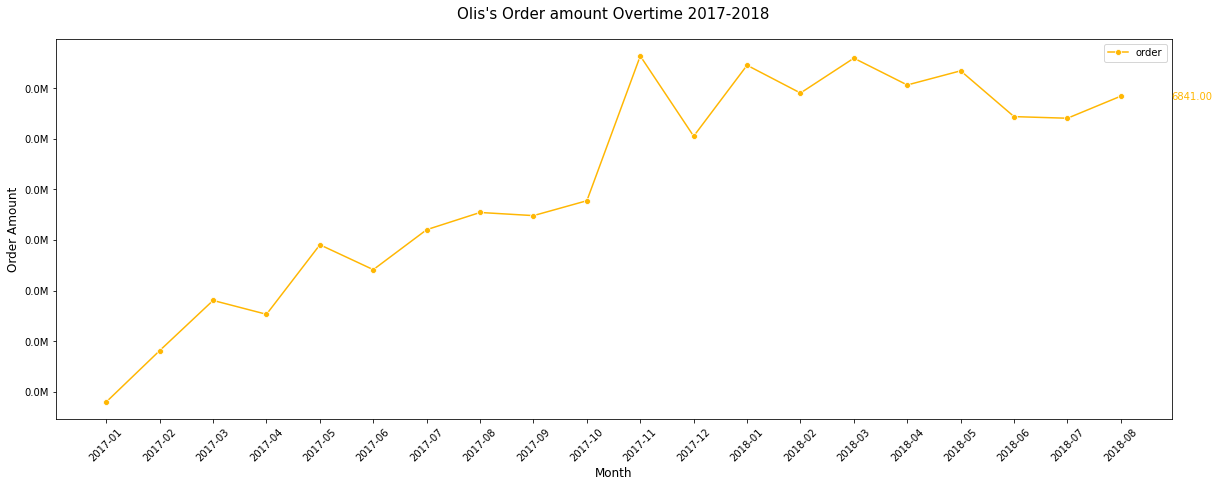

In [ ]:
#visualize 
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
def millions(x, pos):
    return '%1.1fM' % (x * 1e-6)


formatter = FuncFormatter(millions)
plt.figure(figsize=(20,7))
ax1 = sns.lineplot(x=order_overtime.index, y="order_id", data=order_overtime, ci=None, marker="o", color='#ffb703', label='order')
plt.title("Olis's Order amount Overtime 2017-2018", fontsize=15, pad=20)
for l in ax1.lines:
    y = l.get_ydata()
    if len(y)>0:
        ax1.annotate(f'{y[-1]:.2f}', xy=(1,y[-1]), xycoords=('axes fraction', 'data'), 
                     ha='left', va='center', color="#ffb703")
plt.xticks(rotation=45)
ax1.yaxis.set_major_formatter(formatter)
plt.ylabel("Order Amount", fontsize=12)
plt.xlabel("Month", fontsize=12)
plt.grid(False)
plt.legend()
plt.show()

The graph of overtime order amount and revenue is exactly the same, this means that there is fluctuating whether it's an increase or decrease in revenue from this store due to the fultiatif of the number of monthly orders.

## Decomposition of Time Series Data

In [ ]:
# create dataset time series for order amount
new_fcast = data_check.groupby(['order_app_date'])[['order_id']].count().sort_values(by='order_app_date').resample('M').sum()

# drop unrelevant dataset
new_fcast = new_fcast.drop(index=['2016-10-31', '2016-11-30', '2016-12-31', '2018-09-30'])

In [ ]:
# check index
new_fcast.index

DatetimeIndex(['2017-01-31', '2017-02-28', '2017-03-31', '2017-04-30',
               '2017-05-31', '2017-06-30', '2017-07-31', '2017-08-31',
               '2017-09-30', '2017-10-31', '2017-11-30', '2017-12-31',
               '2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30',
               '2018-05-31', '2018-06-30', '2018-07-31', '2018-08-31'],
              dtype='datetime64[ns]', name='order_app_date', freq=None)

Make sure the frequent of our index or datetime is M or month.

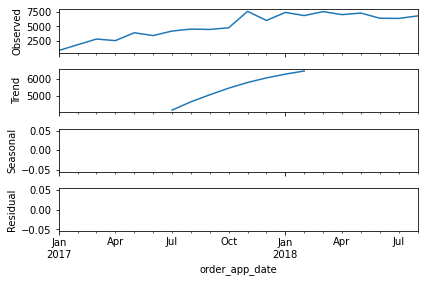

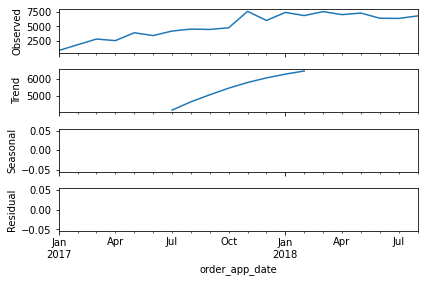

In [ ]:
# let's see decompose of the order amount dataset
## additive model
decom_add = seasonal_decompose(new_fcast, model="additive")
decom_add.plot()

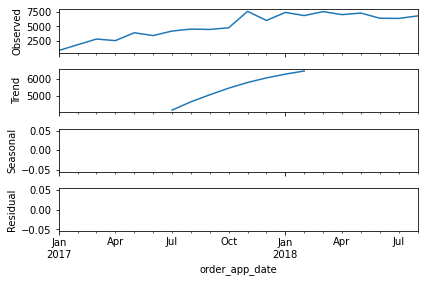

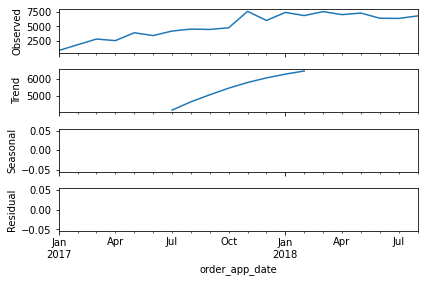

In [ ]:
## multiplicative model
decom_mul = seasonal_decompose(new_fcast, model="multiplicative")
decom_mul.plot()

It is not very clear whether our time series is more suitable to use an additive or multiplicative model. But what can be ascertained from this is that our time series only has **Trend**, does not have **Seasonal and Residual**.


So it can be said that the **order amount variable only depends on the historical data of the variable**. And **does not have seasonality** because the data we have is only one year, it is not enough to define what season has an effect on the increase in the number of orders or sales.


Algorithms that are suitable for data without seasonality are traditional forecasting methods such as **Double Exponential Smoothing and ARIMA**

## Double Exponential Smoothing

In [ ]:
# Additive model

add_fcast = ExponentialSmoothing(new_fcast['order_id'][:-4], trend="additive")
add_res = add_fcast.fit()
forecast_add = add_res.forecast(steps=4)


# Multiplicative model

mul_fcast = ExponentialSmoothing(new_fcast['order_id'][:-4], trend="multiplicative")
mul_res = mul_fcast.fit()
forecast_mul = mul_res.forecast(steps=4)

In [ ]:
# result multiplicative model

forecast_mul

2018-05-31    7232.648741
2018-06-30    7134.588953
2018-07-31    7037.858653
2018-08-31    6942.439816
Freq: M, dtype: float64

In [ ]:
# result additive model

forecast_add

2018-05-31    7872.640898
2018-06-30    8067.998773
2018-07-31    8263.356648
2018-08-31    8458.714523
Freq: M, dtype: float64

In [ ]:
# evaluation model
## Additive model

print("MAPE of Exponential Smoothing Additive Model: ", mean_absolute_percentage_error(forecast_add, new_fcast[-4:]), "%")
print("RMSE of Exponential Smoothing Additive Model: ", rmse(forecast_add, new_fcast[-4:]))
print("Mean Value of Test Dataset:", new_fcast[-4:].mean())
print('\n')
## Multiplicative model
print("MAPE of Exponential Smoothing Multiplicative Model: ", mean_absolute_percentage_error(forecast_mul, new_fcast[-4:]), "%")
print("RMSE of Exponential Smoothing Multiplicative Model: ", rmse(forecast_mul, new_fcast[-4:]))
print("Mean Value of Test Dataset:", new_fcast[-4:].mean())

MAPE of Exponential Smoothing Additive Model:  0.171517805143574 %
RMSE of Exponential Smoothing Additive Model:  [1179.80593184 1366.23251313 1554.85366567 1744.95786824]
Mean Value of Test Dataset: order_id    6755.5
dtype: float64


MAPE of Exponential Smoothing Multiplicative Model:  0.05439308414826274 %
RMSE of Exponential Smoothing Multiplicative Model:  [609.5975486  536.32703104 472.93198124 422.94768572]
Mean Value of Test Dataset: order_id    6755.5
dtype: float64


In [ ]:
rmse_total = (609.5975486+536.32703104+472.93198124+422.94768572)/4
rmse_total

510.45106165

## ARIMA

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(new_fcast, order=(1,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:             D.order_id   No. Observations:                   19
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -154.293
Method:                       css-mle   S.D. of innovations            806.518
Date:                Sun, 05 Jun 2022   AIC                            314.585
Time:                        10:17:14   BIC                            317.419
Sample:                    02-28-2017   HQIC                           315.065
                         - 08-31-2018                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              302.4233    122.618      2.466      0.025      62.096     542.750
ar.L1.D.order_id    -0.5382      0.185     -2.910      0.010      -0.901      -0.176
                            

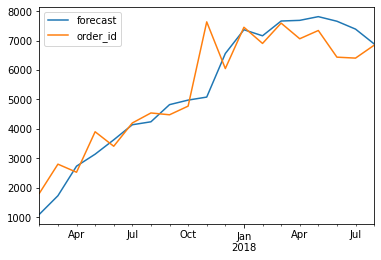

In [ ]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

So far, best model for our forecasting is in multiplicative model using **Double Exponential Smoothing**